# OOD Performance assessment

In [2]:
ls ../Results/Generalizability

Skin_cSCC2BC_Her2ST/      Skin_Melanoma2BC_visium/
Skin_cSCC2Skin_Melanoma/  Skin_Melanoma2Skin_cSCC/


In [3]:
import glob
import os
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import tqdm
import gc
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import issparse

def get_R(data1,data2,dim=1,func=pearsonr):
    adata1=data1.X
    adata2=data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata2 = adata2.toarray() if issparse(adata2) else adata2
    
    r1,p1=[],[]
    for g in range(data1.shape[dim]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g], alternative='greater')
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:], alternative='greater')
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1

def get_ssim(data1, data2, num_breaks=None):
    """
    Some info about SSIM computation.
    data1: the ground truth data
    data2: the predicted data
    dim: the dimension to calculate the SSIM. If the dim = 1, calculate the SSIM at gene-wise, otherwise calculate the SSIM at spot-wise.
    """
    adata1 = data1.X
    adata2 = data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2

    SSIM = []
    for g in range(adata1.shape[1]):
        x = adata1[:,g]
        y = adata2[:,g]
        # Normalize the arrays if their maximum values are not zero
        x = x if np.max(x) == 0 else x / np.max(x)
        y = y if np.max(y) == 0 else y / np.max(y)  
    
        if num_breaks:
            # Discretize the normalized arrays into 'num_breaks' bins
            x = np.digitize(x, np.linspace(0, 1, num_breaks), right=False) - 1
            y = np.digitize(y, np.linspace(0, 1, num_breaks), right=False) - 1
            
            # Constants used in SSIM calculation
            C1 = (0.01 * (num_breaks - 1))**2
            C2 = (0.03 * (num_breaks - 1))**2
        else:
            C1 = (0.01)**2
            C2 = (0.03)**2
        
        mux = np.mean(x)
        muy = np.mean(y) 
        sigxy = np.cov(x, y)[0, 1]
        sigx = np.var(x)
        sigy = np.var(y)
        
        ssim = ((2 * mux * muy + C1) * (2 * sigxy + C2)) / ((mux**2 + muy**2 + C1) * (sigx + sigy + C2))
        SSIM.append(ssim)
        assert -1 <= ssim <= 1, "SSIM should be within the valid range [-1, 1]"
        
    return SSIM

def get_cosine(data1, data2):
    # Convert the anndata to numpy array
    adata1=data1.X.T
    adata2=data2.X.T
    # Calculate the consine similarity at gene wise
    cosine_sim = cosine_similarity(adata1, adata2)
    # Take the diag of similarity matrix
    cosine_score = np.diag(cosine_sim)
    return cosine_score

def make_res(source_dataset, target_dataset, methods, names, distributed, ensemble=True):
    RESULTS_DIR = "../Results/Generalizability"
    SUMMARY_DIR = "../Results/Summary/Generalizability"

    if ensemble:
        model_no = "mean"
    else:
        model_no = 0

    for method in tqdm.tqdm(methods):
        if distributed:
            gc.collect()
            name = names[fold]
            file_path = os.path.join(RESULTS_DIR, f"{source_dataset}2{target_dataset}", f"pred_{method}_{source_dataset}_{target_dataset}_{name}_{model_no}.h5ad")

            if os.path.exists(file_path):
                data1 = sc.read_h5ad(os.path.join(RESULTS_DIR, f"{source_dataset}2{target_dataset}", f"gt_{method}_{source_dataset}_{target_dataset}_{name}.h5ad"))
                data2 = sc.read_h5ad(file_path)
                spatial_matrix = np.load(os.path.join(RESULTS_DIR, f"{source_dataset}2{target_dataset}", f"spatial_loc_{method}_{source_dataset}_{target_dataset}_{name}_func.npy"))
                data2.var_names = data1.var_names
                pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
                SPC, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
                ssim_score = get_ssim(data1, data2)
                cosine_score = get_cosine(data1, data2)

                PCC_BC_Visium = {
                    "Gene": list(data1.var_names),
                    "Pearson correlation": pcc,
                    "PCC_PValue": PCC_PValue,
                    "Spearmanr correlation": SPC,
                    "SPC_PValue": SPC_PValue,
                    "SSIM_Score": ssim_score,
                    "Cosine_Score": cosine_score,
                    "Slides": [name] * len(pcc),
                    "Dataset": [f"{source_dataset}_{target_dataset}"] * len(pcc),
                    "Method": [method] * len(pcc),
                }

                pcc_bc_visium = pd.DataFrame(PCC_BC_Visium)
                summary_dir = os.path.join(SUMMARY_DIR, f"{source_dataset}2{target_dataset}")

                if not os.path.exists(summary_dir):
                    os.mkdir(summary_dir)

                pcc_bc_visium.to_csv(os.path.join(RESULTS_DIR, f"{source_dataset}2{target_dataset}", f"{method}_{source_dataset}_{target_dataset}_{name}_nonMI.csv"))
            else:
                print(f"The file {file_path} does not exist. Skipping.")

    print("Organize the results into summary file!")
    res = glob.glob(os.path.join(RESULTS_DIR, f"{source_dataset}2{target_dataset}", "*_nonMI.csv"))
    df = pd.concat([pd.read_csv(i, index_col=[0]) for i in res])

    summary_dir = os.path.join(SUMMARY_DIR, f"{source_dataset}2{target_dataset}")

    if not os.path.exists(summary_dir):
        os.mkdir(summary_dir)

    df.to_csv(os.path.join(SUMMARY_DIR, f"{source_dataset}2{target_dataset}_summary_nonMI_{model_no}.csv"))
    return df

def top_predictable_genes(df_results: pd.DataFrame, dataset: str, method: str, num: int = 5) -> pd.DataFrame:
    """
    Extracts the top predictable genes based on Pearson correlation for a specific method and dataset.

    Parameters:
        - df_results (pd.DataFrame): The DataFrame containing the results from the make_res function.
        - dataset (str): The dataset name.
        - method (str): The method name.
        - num (int, optional): The number of top predictable genes or "pos" for all positive Pearson correlation values.

    Returns:
        pd.DataFrame: DataFrame containing the top predictable genes and related statistics.
    """
    df = df_results[df_results["Method"] == method]

    if num == "pos":
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False)
    else:
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False).head(num)

    top_genes = list(top_df.index)

    # Calculate the number of consistent samples for each top gene
    num_pos = [df[df["Gene"] == g]['Pearson correlation'].gt(0).sum() for g in top_genes]

    # Create the final DataFrame with relevant columns
    top_df["Number of consistent samples"] = num_pos
    top_df["Method"] = method
    top_df["Dataset"] = dataset
    top_df = top_df[[('Method', ''), ('Dataset', ''), ('Number of consistent samples', ''),
                     ('Pearson correlation', 'mean'), ('Pearson correlation', 'median'),
                     ('Pearson correlation', 'min'), ('Pearson correlation', 'max'),
                     ('Pearson correlation', 'std')]]

    return top_df


In [12]:
Skin_cSCC2BC_Her2ST: bleep
Skin_cSCC2Skin_Melanoma : bleep


252

In [4]:
import glob

for method in ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]:
    print(method)
    print(len(glob.glob(f"../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_{method}*.h5ad")))

deeppt
70
hist2st
70
histogene
70
stimage
70
stnet
70
deepspace
70
bleep
23


In [8]:
glob.glob(f"../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep*.h5ad")

['../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_4.h5ad',
 '../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_5.h5ad',
 '../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_10.h5ad',
 '../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_6.h5ad',
 '../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_C1_8.h5ad',
 '../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_mean.h5ad',
 '../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_8.h5ad',
 '../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_3.h5ad',
 '../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_C1_0.h5ad',
 '../R

## Skin_Melanoma2BC_visium

In [5]:
# ls ../Results/Summary/Generalizability/

In [ ]:
source_dataset = "Skin_Melanoma"
target_dataset = "BC_visium"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

for fold in range(9):
    df = make_res(source_dataset, target_dataset, Methods, names, distributed=True, ensemble=False)


In [8]:
df

,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Dataset,Method
0,PSEN2,0.060283,0.001283,0.065797,4.978203e-04,0.058370,0.428090,FFPE,Skin_Melanoma_BC_visium,stimage
1,PIK3R5,-0.041821,0.981733,-0.029772,9.316482e-01,-0.014990,0.383148,FFPE,Skin_Melanoma_BC_visium,stimage
2,MKI67,0.005945,0.383190,0.017347,1.929792e-01,0.020225,0.310627,FFPE,Skin_Melanoma_BC_visium,stimage
3,DKK2,-0.021250,0.855899,-0.009899,6.895967e-01,0.002070,0.191978,FFPE,Skin_Melanoma_BC_visium,stimage
4,NFKB1,0.087413,0.000006,0.096231,7.165211e-07,0.078386,0.674254,FFPE,Skin_Melanoma_BC_visium,stimage
...,...,...,...,...,...,...,...,...,...,...
1205,GNG7,0.000784,0.490129,0.016821,2.976023e-01,0.004706,0.407975,CID4535,Skin_Melanoma_BC_visium,bleep
1206,LAMB4,0.064989,0.019953,0.053069,4.674315e-02,0.004190,0.071984,CID4535,Skin_Melanoma_BC_visium,bleep
1207,DDX41,0.065841,0.018684,0.059309,3.040850e-02,0.065407,0.755411,CID4535,Skin_Melanoma_BC_visium,bleep
1208,THRAP3,0.017290,0.292491,-0.005506,5.690250e-01,0.026576,0.736500,CID4535,Skin_Melanoma_BC_visium,bleep


In [16]:
df.groupby(["Gene"]).agg({
        'Pearson correlation': 'mean',}).sort_values("Pearson correlation", ascending=False)

,Pearson correlation
Gene,
CD44,0.048915
IER3,0.036457
COLEC12,0.031606
SOX9,0.027833
PIK3R1,0.027572
...,...
TPX2,-0.026760
HMGA1,-0.027492
CXCL14,-0.028759


## Skin_Melanoma2cSCC

In [49]:
# ls ../Results/Generalizability/Skin_Melanoma2Skin_cSCC

In [ ]:
source_dataset = "Skin_Melanoma"
target_dataset = "Skin_cSCC"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{dataset_name}/gt_stimage_{dataset_name}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

for fold in range(12):
    df = make_res(source_dataset, target_dataset, Methods, names, distributed=True, ensemble=False)


In [47]:
df

,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Dataset,Method
0,C1QB,-0.033963,0.865935,-0.043351,0.921278,0.006575,0.131071,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
1,ITGB7,-0.014295,0.679385,-0.010634,0.635563,0.017267,0.026645,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
2,PDGFB,-0.026616,0.807229,-0.023256,0.775820,0.012509,0.104104,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
3,PDGFRA,-0.017543,0.716295,-0.000268,0.503479,0.013266,0.092634,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
4,EIF4A2,-0.063526,0.980904,-0.065281,0.983421,-0.015762,0.221867,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
...,...,...,...,...,...,...,...,...,...,...
1101,BAX,-0.069694,0.958540,-0.066968,0.952142,-0.008180,0.168945,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1102,SHC3,-0.037349,0.823410,-0.027336,0.751558,-0.000843,0.115090,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1103,ZC3H12A,0.034899,0.192837,0.033844,0.200104,0.009998,0.258671,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1104,BMPR1B,-0.027343,0.751617,-0.035346,0.810195,0.000097,0.061851,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene


## Skin_cSCC_BC_Her2ST

In [110]:
# ls ../Results/Generalizability/

In [ ]:
source_dataset = "Skin_cSCC"
target_dataset = "BC_Her2ST"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

for fold in range(36):
    df = make_res(source_dataset, target_dataset, Methods, names, distributed=True, ensemble=False)


In [117]:
#Her2ST is missing

In [118]:
df

,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Dataset,Method
0,C1QB,-0.033963,0.865935,-0.043351,0.921278,0.006575,0.131071,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
1,ITGB7,-0.014295,0.679385,-0.010634,0.635563,0.017267,0.026645,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
2,PDGFB,-0.026616,0.807229,-0.023256,0.775820,0.012509,0.104104,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
3,PDGFRA,-0.017543,0.716295,-0.000268,0.503479,0.013266,0.092634,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
4,EIF4A2,-0.063526,0.980904,-0.065281,0.983421,-0.015762,0.221867,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
...,...,...,...,...,...,...,...,...,...,...
1101,BAX,-0.069694,0.958540,-0.066968,0.952142,-0.008180,0.168945,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1102,SHC3,-0.037349,0.823410,-0.027336,0.751558,-0.000843,0.115090,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1103,ZC3H12A,0.034899,0.192837,0.033844,0.200104,0.009998,0.258671,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1104,BMPR1B,-0.027343,0.751617,-0.035346,0.810195,0.000097,0.061851,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene


## Skin_cSCC2Skin_Melanoma

In [119]:
# Bleep is missing

In [ ]:
source_dataset = "Skin_cSCC"
target_dataset = "Skin_Melanoma"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

for fold in range(5):
    df = make_res(source_dataset, target_dataset, Methods, names, distributed=True, ensemble=False)


In [4]:
ls ../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_*

../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_0.h5ad
../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_10.h5ad
../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_11.h5ad
../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_1.h5ad
../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_2.h5ad
../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_3.h5ad
../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_4.h5ad
../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_5.h5ad
../Results/Generalizability/Skin_cSCC2Skin_Melanoma/pred_bleep_Skin_cSCC_Skin_Melanoma_Visium29_B1_6.h5ad
../Results/Generalizability/Skin_cSCC2Skin_M

In [61]:
df

,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Dataset,Method
0,C1QB,0.450602,1.381030e-125,0.429378,5.326360e-113,0.336303,0.697622,Visium38_D1,Skin_cSCC_Skin_Melanoma,deeppt
1,MST1R,0.189405,6.355909e-22,0.207826,4.275252e-26,0.102421,0.368043,Visium38_D1,Skin_cSCC_Skin_Melanoma,deeppt
2,MYH9,0.462197,7.542381e-133,0.472431,1.696139e-139,0.361198,0.755419,Visium38_D1,Skin_cSCC_Skin_Melanoma,deeppt
3,ITCH,0.163862,8.273846e-17,0.159005,6.363685e-16,0.044297,0.326474,Visium38_D1,Skin_cSCC_Skin_Melanoma,deeppt
4,WEE1,0.148018,5.103320e-14,0.169776,6.335952e-18,0.093585,0.286887,Visium38_D1,Skin_cSCC_Skin_Melanoma,deeppt
...,...,...,...,...,...,...,...,...,...,...
1101,RBX1,-0.066417,9.999328e-01,-0.074443,9.999907e-01,-0.026180,0.443980,Visium29_C1,Skin_cSCC_Skin_Melanoma,deepspace
1102,MAP2K6,0.010901,2.656514e-01,0.005003,3.869425e-01,0.037906,0.046496,Visium29_C1,Skin_cSCC_Skin_Melanoma,deepspace
1103,MAP2K2,-0.085281,9.999995e-01,-0.097417,1.000000e+00,-0.040011,0.461076,Visium29_C1,Skin_cSCC_Skin_Melanoma,deepspace
1104,BCR,0.019377,1.328999e-01,0.011086,2.621858e-01,0.032862,0.409484,Visium29_C1,Skin_cSCC_Skin_Melanoma,deepspace


# Visiualize the results

In [122]:
ls ../Results/Summary/Generalizability/

OOD_summary_nonMI_ensemble.csv
Skin_cSCC2BC_Her2ST/
Skin_cSCC2BC_Her2ST_summary_nonMI_0.csv
Skin_cSCC2BC_Her2ST_summary_nonMI.csv
Skin_cSCC2Skin_Melanoma/
Skin_cSCC2Skin_Melanoma_summary_nonMI.csv
Skin_cSCC2Skin_Melanoma_summary_nonMI_mean.csv
Skin_Melanoma2BC_visium/
Skin_Melanoma2BC_visium_summary_nonMI_0.csv
Skin_Melanoma2BC_visium_summary_nonMI.csv
Skin_Melanoma2Skin_cSCC/
Skin_Melanoma2Skin_cSCC_summary_nonMI_0.csv
Skin_Melanoma2Skin_cSCC_summary_nonMI.csv
Skin_Melanoma2Skin_cSCC_summary_nonMI_mean.csv


In [196]:
# # Define mapping dictionaries for model and dataset names
# model_mapping = {
#     'deeppt': "DeepPT",
#     'histogene': "HisToGene",
#     'His2gene': "HisToGene",
#     'stnet': "STnet",
#     'hist2st': "Hist2ST",
#     'stimage': "STimage",
#     'bleep': "BLEEP",
#     'deepspace': "DeepSpaCE"
# }

# # Replace model and dataset names in the DataFrame
# df_OOD.replace({'Method': model_mapping,}, inplace=True)

# # Define the order for Dataset and Method columns
# dataset_order = ['Skin_cSCC_BC_Her2ST', 'Skin_cSCC_Skin_Melanoma', 'Skin_Melanoma_BC_visium', 'Skin_Melanoma_Skin_cSCC']
# method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

# # Use pd.Categorical directly during DataFrame creation
# df_OOD['Dataset'] = pd.Categorical(df_OOD['Dataset'], categories=dataset_order, ordered=True)
# df_OOD['Method'] = pd.Categorical(df_OOD['Method'], categories=method_order, ordered=True)


In [218]:
df_OOD = pd.read_csv("../Results/Summary/Generalizability/OOD_summary_nonMI_ensemble.csv")
df_ID = pd.read_csv("../Results/Summary/ID_func_metrics.csv")
df_ID = df_ID[df_ID["Dataset"].isin(["Skin_cSCC", "BC_Her2ST", "Skin_Melanoma", "BC_Visium"])]
df2 = pd.concat([df_ID, df_OOD])

In [219]:
df2.Dataset.unique()

array(['BC_Her2ST', 'BC_Visium', 'Skin_Melanoma', 'Skin_cSCC',
       'Skin_cSCC_BC_Her2ST', 'Skin_cSCC_Skin_Melanoma',
       'Skin_Melanoma_BC_visium', 'Skin_Melanoma_Skin_cSCC'], dtype=object)

In [220]:
dataset_mapping = {
    'BC_Her2ST': "BC_Her2ST-ID",
    'Skin_cSCC': "Skin_cSCC-ID",
    'Skin_Melanoma': "Skin_Melanoma-ID",
    'BC_Visium': "BC_Visium-ID",
    'Skin_cSCC_BC_Her2ST': "BC_Her2ST-OOD",
    'Skin_cSCC_Skin_Melanoma': "Skin_Melanoma-OOD",
    'Skin_Melanoma_BC_visium': "BC_Visium-OOD",
    'Skin_Melanoma_Skin_cSCC': "Skin_cSCC-OOD"
}
df2.replace({'Dataset': dataset_mapping,}, inplace=True)


dataset_order = ['BC_Her2ST-ID', 'BC_Her2ST-OOD', 
                 'Skin_Melanoma-ID', 'Skin_Melanoma-OOD',  
                 'BC_Visium-ID', 'BC_Visium-OOD', 
                 'Skin_cSCC-ID', 'Skin_cSCC-OOD', ]
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

df2['Dataset'] = pd.Categorical(df2['Dataset'], categories=dataset_order, ordered=True)
df2['Method'] = pd.Categorical(df2['Method'], categories=method_order, ordered=True)


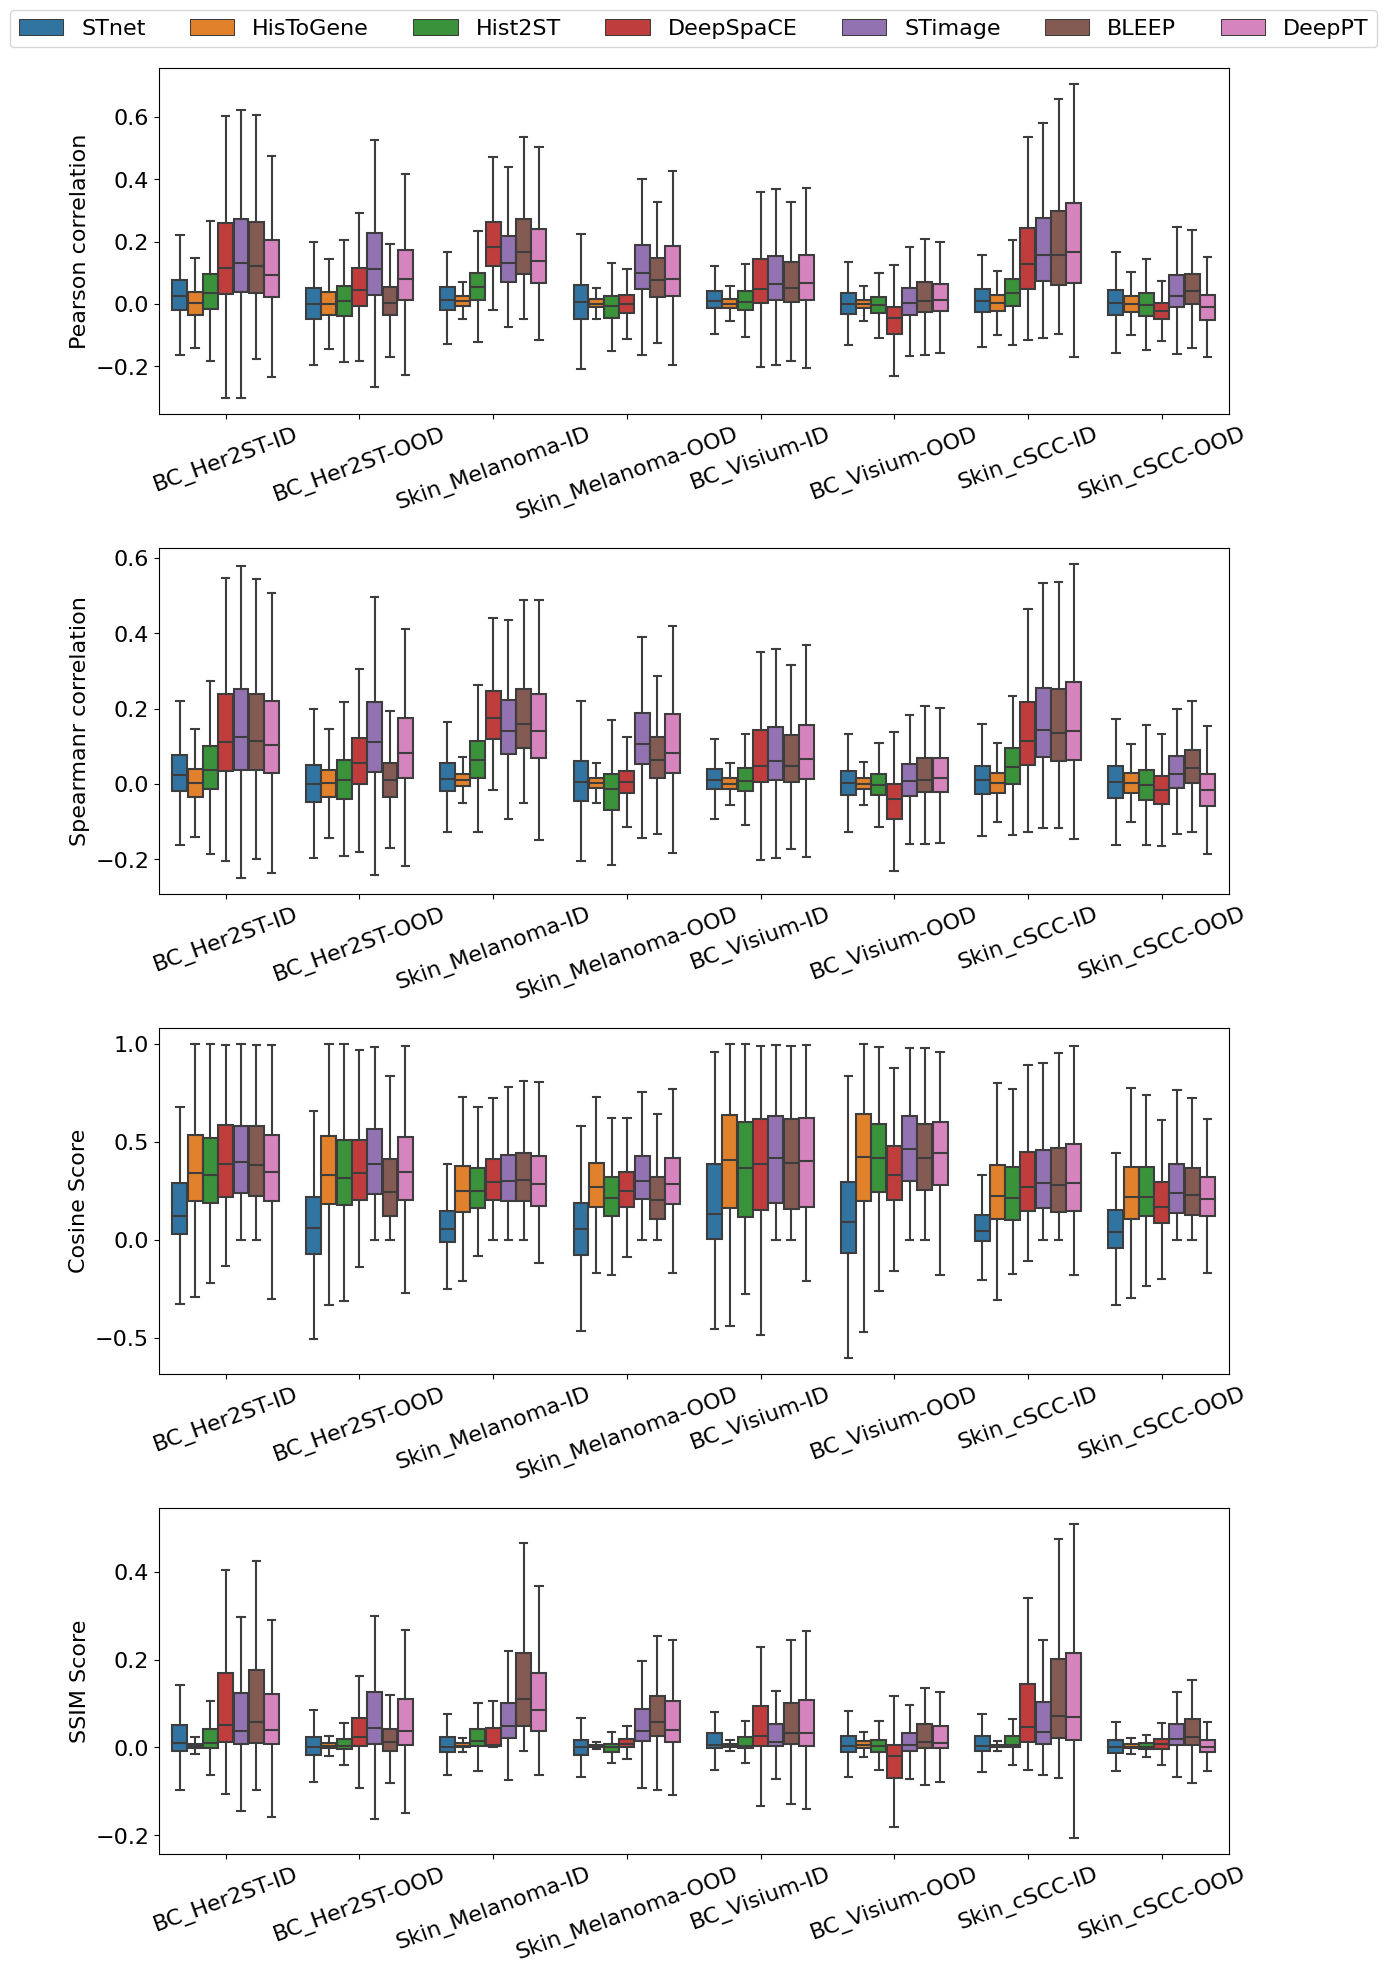

85808

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with 4 rows and 1 column
fig, axs = plt.subplots(4, 1, figsize=(14, 20))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', True),
    ('Spearmanr correlation', 'Spearmanr correlation', False),
    ('Cosine_Score', 'Cosine Score', False),
    # ("Moran'I_Score", "Moran's I Score", False),
    ('SSIM_Score', 'SSIM Score', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    sns.boxplot(x='Dataset', y=column, hue='Method', data=df2, ax=axs[i], showfliers=False, orient="v")
    
    # Rotate x-axis labels with 10 degrees
    axs[i].tick_params(axis='x', labelrotation=20)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[i].get_legend().remove()
    
    axs[i].set_xlabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[i].set_ylabel(ylabel)

# Move the legend outside the plot area only for the first subplot
pos = axs[0].get_position()
axs[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
axs[0].legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.2),
    ncol=7,
)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
plt.savefig("FigureS5.pdf", dpi=300)

# Show the plots
plt.show()

# Collect garbage to free up memory
gc.collect()


# Figure S5

## Predictable genes

In [233]:
# Specify the directory for functional gene results
functional_results_directory = "../Results/Summary/"

# Specify the directory for predictable gene results
predictable_results_directory = "../Results/Predictable_res/"

# List of dataset names
datasets = ['BC_Her2ST-ID', 'BC_Visium-ID', 'Skin_Melanoma-ID', 'Skin_cSCC-ID', 
            'BC_Her2ST-OOD', 'Skin_Melanoma-OOD', 'BC_Visium-OOD', 'Skin_cSCC-OOD']

# Iterate over datasets
for dataset_name in datasets:
    # Read the functional gene results for the current dataset
    df_func = df2[df2["Dataset"]==dataset_name]

    # List of methods
    methods = ['HisToGene', 'Hist2ST', 'STimage', 'STnet', 'DeepSpaCE', 'DeepPT', 'BLEEP']

    # Get predictable genes for each method
    predictable_genes_sets = [set(top_predictable_genes(df_func, dataset_name, method, num=500).index) for method in methods]

    # Find the intersection of predictable genes across all methods
    predictable_genes = list(set.intersection(*predictable_genes_sets))
    print(f"There are {len(predictable_genes)} genes that are predictable by all methods for {dataset_name}.")

    # Subset the original DataFrame for predictable genes
    df_predictable = df_func[df_func["Gene"].isin(predictable_genes)].reset_index(drop=True)

    # Save the results for predictable genes
    predictable_results_path = os.path.join(predictable_results_directory, f"predictable_{dataset_name}_OOD.csv")
    df_predictable.to_csv(predictable_results_path)

# Load the results of predictable genes
predictable_results_glob = os.path.join(predictable_results_directory, "predictable_*-*_OOD.csv")
df_combined_predictable = pd.concat([pd.read_csv(r, index_col=[0]) for r in glob.glob(predictable_results_glob)], ignore_index=True)
df_combined_predictable


There are 115 genes that are predictable by all methods for BC_Her2ST-ID.
There are 58 genes that are predictable by all methods for BC_Visium-ID.
There are 152 genes that are predictable by all methods for Skin_Melanoma-ID.
There are 110 genes that are predictable by all methods for Skin_cSCC-ID.
There are 19 genes that are predictable by all methods for BC_Her2ST-OOD.
There are 12 genes that are predictable by all methods for Skin_Melanoma-OOD.
There are 4 genes that are predictable by all methods for BC_Visium-OOD.
There are 1 genes that are predictable by all methods for Skin_cSCC-OOD.


,Unnamed: 0,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Moran'I_Score,Slides,Dataset,Method,Unnamed: 0.1
0,399175,7.0,TNFSF10,0.245483,6.368130e-55,0.254419,5.691491e-59,0.250289,0.850828,0.216137,block2,BC_Visium-ID,STnet,NaN
1,399180,12.0,CHD4,0.192932,2.565533e-34,0.190932,1.224923e-33,0.136564,0.561509,0.163842,block2,BC_Visium-ID,STnet,NaN
2,399220,52.0,RRM2,0.038338,8.325891e-03,0.043287,3.428728e-03,0.046833,0.626540,0.033823,block2,BC_Visium-ID,STnet,NaN
3,399277,109.0,NSD1,0.067529,1.217840e-05,0.067027,1.399649e-05,0.067774,0.462678,0.037629,block2,BC_Visium-ID,STnet,NaN
4,399343,175.0,USP9X,0.074344,1.677889e-06,0.075388,1.219553e-06,0.072930,0.561900,0.080433,block2,BC_Visium-ID,STnet,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52039,917,NaN,PDIA4,0.361379,5.500862e-11,0.373333,1.174578e-11,0.365055,0.811910,NaN,D6,BC_Her2ST-OOD,STnet,244608.0
52040,938,NaN,CNOT2,0.091023,5.783110e-02,0.082957,7.588135e-02,0.092531,0.480666,NaN,D6,BC_Her2ST-OOD,STnet,244629.0
52041,943,NaN,C1QB,0.246551,7.822049e-06,0.227851,3.409231e-05,0.246025,0.784193,NaN,D6,BC_Her2ST-OOD,STnet,244634.0
52042,1007,NaN,CTNND1,0.134187,1.003576e-02,0.155085,3.559290e-03,0.103286,0.461455,NaN,D6,BC_Her2ST-OOD,STnet,244698.0


In [237]:
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']
datasets = ['BC_Her2ST-ID', 'BC_Visium-ID', 'Skin_Melanoma-ID', 'Skin_cSCC-ID', 
            'BC_Her2ST-OOD', 'Skin_Melanoma-OOD', 'BC_Visium-OOD', 'Skin_cSCC-OOD']

df_combined_predictable['Method'] = pd.Categorical(df_combined_predictable['Method'], categories=method_order, ordered=True)
df_combined_predictable['Dataset'] = pd.Categorical(df_combined_predictable['Dataset'], categories=dataset_order, ordered=True)


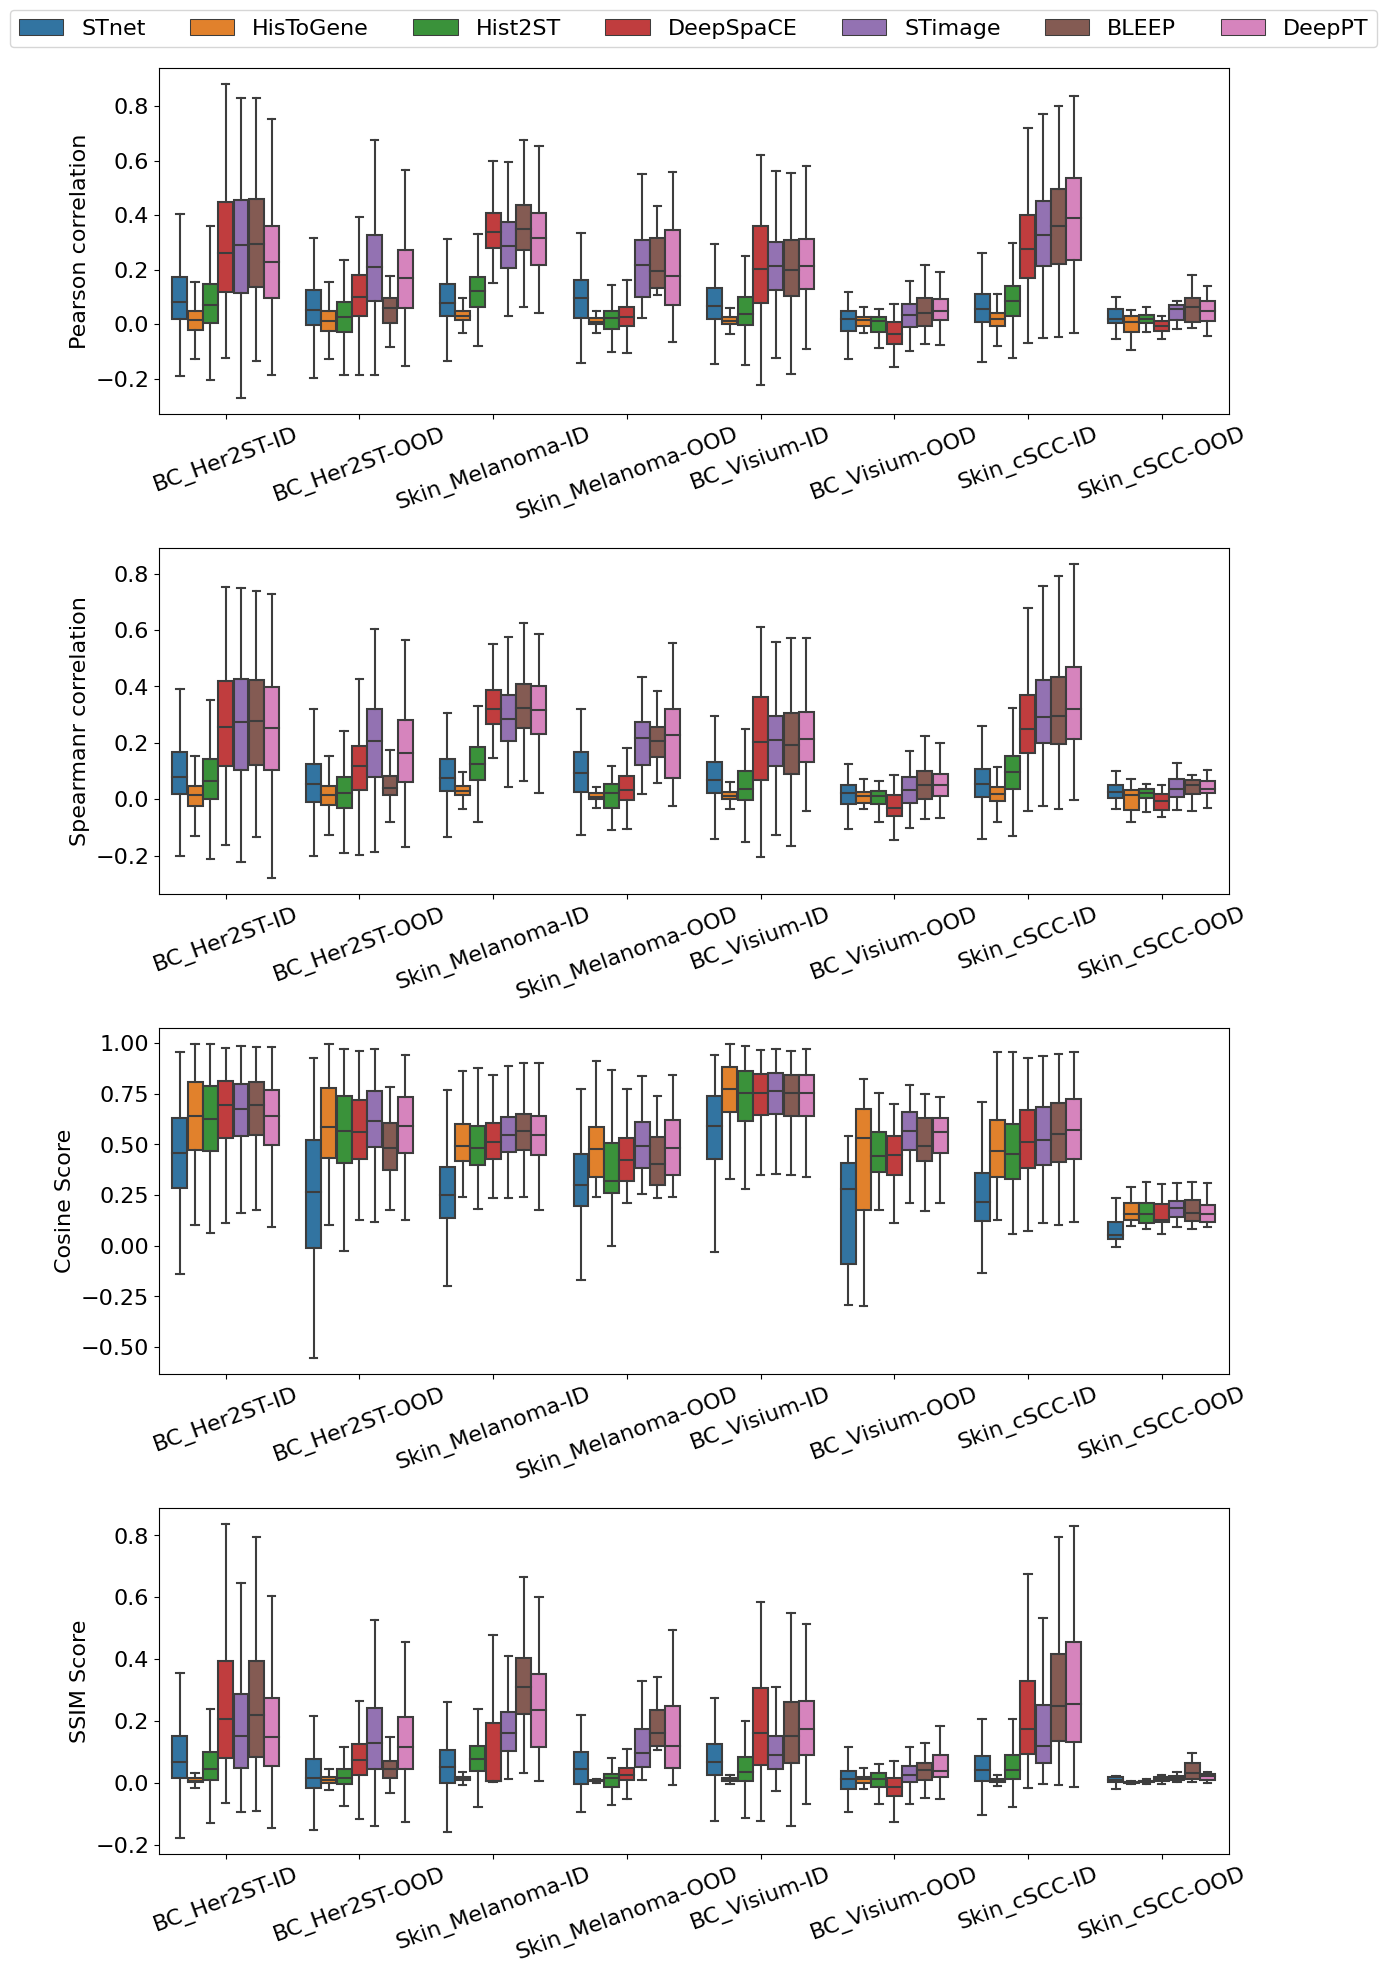

109725

In [238]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with 4 rows and 1 column
fig, axs = plt.subplots(4, 1, figsize=(14, 20))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', True),
    ('Spearmanr correlation', 'Spearmanr correlation', False),
    ('Cosine_Score', 'Cosine Score', False),
    # ("Moran'I_Score", "Moran's I Score", False),
    ('SSIM_Score', 'SSIM Score', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    sns.boxplot(x='Dataset', y=column, hue='Method', data=df_combined_predictable, ax=axs[i], showfliers=False, orient="v")
    
    # Rotate x-axis labels with 10 degrees
    axs[i].tick_params(axis='x', labelrotation=20)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[i].get_legend().remove()
    
    axs[i].set_xlabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[i].set_ylabel(ylabel)

# Move the legend outside the plot area only for the first subplot
pos = axs[0].get_position()
axs[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
axs[0].legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.2),
    ncol=7,
)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
plt.savefig("Figure5.pdf")

# Show the plots
plt.show()

# Collect garbage to free up memory
gc.collect()
